In [26]:
import sys
sys.path.append("..")

In [27]:
# Imports
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from src.utils.image_utils import get_sample_image_size
from src.utils.file_utils import train_test_split, num_images
import torch.optim as optim
from tqdm.notebook import tqdm


set computation device

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cpu


set hyper parameters

In [29]:
EPOCHS = 10
BATCH = 64

# percent of all data to go towards testing and validation
TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15

#### load the train and test data

In [30]:
original_data = "../data/spectrograms/high_30_500"
data_dir = "../data/organized_spectrograms/high_30_500"
train_dir, test_dir = train_test_split(original_data, data_dir, PERCENT_TESTING)

Number of images per class: [0, 0]
Number of testing images per class: [0, 0]


In [31]:
image_size = get_sample_image_size(os.path.join(data_dir, "training/top"))
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")


Number of channels in the image: 1
height: 128, width: 646


In [32]:
transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = ImageFolder(train_dir,transform = transform)
test_dataset = ImageFolder(test_dir,transform = transform)

#### Looking at the dataset

In [33]:
img, label = dataset[0]
print(img.shape,label)
print("classes : \n",dataset.classes)

torch.Size([1, 128, 646]) 0
classes : 
 ['bottom', 'top']


display the first image in the dataset

Label : bottom


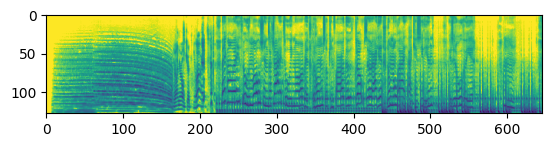

In [34]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*dataset[0])

load the train and validation into batches.

In [35]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(TRACKS_PER_CLASS*PERCENT_VALIDATION)
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle = True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)


Length of Train Data : 769
Length of Validation Data : 75


visualize a single batch of images

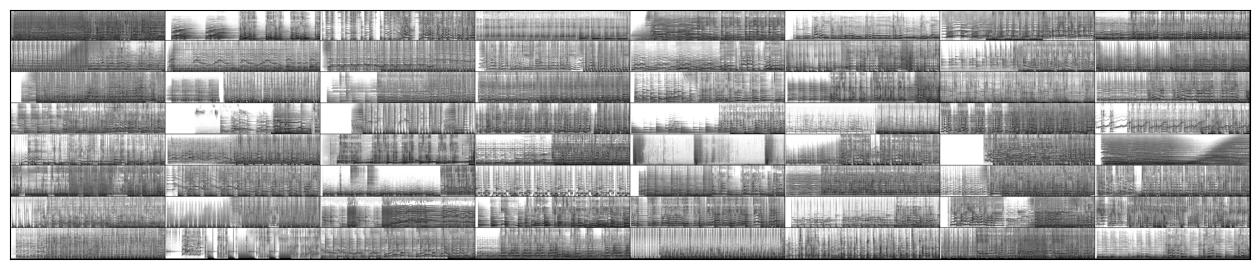

In [36]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)

In [37]:
import torch.nn as nn

class VGG11(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the size of the feature maps after convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_output_size = self.calculate_conv_output_size(in_channels, WIDTH, HEIGHT)

        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=self.conv_output_size, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )

    def calculate_conv_output_size(self, in_channels, width, height):
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, width, height)
            dummy_output = self.conv_layers(dummy_input)
            print(f'Dummy output shape: {dummy_output.shape}')
            return dummy_output.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Initialize model:

In [38]:
model = VGG11(in_channels=1, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Dummy output shape: torch.Size([1, 512, 20, 4])


Function for training (one epoch)

In [39]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    cum_loss = 0.0
    cum_correct = 0

    for (x,y) in tqdm(trainloader, total=len(trainloader), desc='Training'):
        (x, y) = (x.to(device), y.to(device))         
        pred = model(x) 
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        cum_correct += (pred.argmax(1) == y).sum().item()

    epoch_acc = cum_correct / len(trainloader.dataset)
    epoch_loss = cum_loss / len(trainloader)
    return epoch_acc, epoch_loss

Function for testing (one epoch)

In [40]:
def test(model, testloader, criterion):
    model.eval()
    cum_loss = 0.0
    cum_correct = 0

    with torch.no_grad():
        for (x,y) in tqdm(testloader, total=len(testloader), desc='Testing'):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x) 
            loss = criterion(pred, y)
            cum_loss += loss
            cum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    epoch_acc = cum_correct / len(testloader.dataset)
    epoch_loss = cum_loss / len(testloader)
    return epoch_acc, epoch_loss

Training and testing the model:

In [41]:
# dictionary to keep track of losses and accuracies
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": [],
}

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_acc, train_epoch_loss = train(model, train_dl, optimizer, criterion)
    test_epoch_acc, test_epoch_loss = test(model, test_dl, criterion)

    H["train_loss"].append(train_epoch_loss)
    H["train_acc"].append(train_epoch_acc)
    H["test_loss"].append(test_epoch_loss)
    H["test_acc"].append(test_epoch_acc)

Epoch 1 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 of 10


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ViralityClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(163840,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
model = ViralityClassification()
model

ViralityClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=163840, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linea

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ViralityClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=163840, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linea

In [ ]:
#load the model to the device
model = to_device(ViralityClassification(),device)


In [ ]:
#initial evaluation of the model
evaluate(model,val_dl)

{'val_loss': 1.7862176895141602, 'val_acc': 0.0}

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 4.6375, val_loss: 1.3054, val_acc: 0.4600
Epoch [1], train_loss: 1.1087, val_loss: 0.8395, val_acc: 0.4600
Epoch [2], train_loss: 0.8005, val_loss: 0.6983, val_acc: 0.5400
Epoch [3], train_loss: 0.7276, val_loss: 0.7560, val_acc: 0.4600
Epoch [4], train_loss: 0.7193, val_loss: 0.6974, val_acc: 0.4600
Epoch [5], train_loss: 0.6973, val_loss: 0.6905, val_acc: 0.5400


KeyboardInterrupt: 